In [27]:
import os
import numpy as np
import pandas as pd

os.chdir('../core')

In [2]:
DATA_DIR = "../data"
FILE_NAME = "train.csv"

df = pd.read_csv(os.path.join(DATA_DIR, FILE_NAME))
df = df.drop(columns=["Employee ID"])
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df["Attrition"] = df["Attrition"].map({"Stayed": 1, "Left": 0})
print(df.shape)

df.head(5)

(59598, 23)


,Age,Gender,Years at Company,Job Role,Monthly Income,Work-Life Balance,Job Satisfaction,Performance Rating,Number of Promotions,Overtime,...,Number of Dependents,Job Level,Company Size,Company Tenure,Remote Work,Leadership Opportunities,Innovation Opportunities,Company Reputation,Employee Recognition,Attrition
0,29,Female,10,Education,4262,Fair,Medium,High,0,Yes,...,0,Senior,Small,52,No,No,No,Poor,High,1
1,18,Male,3,Finance,9032,Good,Very High,High,3,Yes,...,3,Entry,Medium,50,No,No,No,Good,Medium,0
2,30,Female,9,Healthcare,8610,Poor,Medium,Average,2,No,...,4,Entry,Large,62,No,No,No,Fair,Low,0
3,46,Male,2,Education,5071,Fair,High,Average,1,Yes,...,0,Entry,Small,39,No,No,No,Good,High,0
4,37,Male,17,Technology,10037,Fair,High,Average,0,No,...,1,Mid,Medium,42,No,No,No,Good,Low,0


In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

from processor import LabelEncoderTransformer


target_column = "Attrition"

# Choose numeric columns except the target column
numeric_columns = df.drop(columns=[target_column]).select_dtypes(include=['int64', 'float64']).columns.tolist()
category_columns = df.select_dtypes(include=['object']).columns.tolist()

processor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', LabelEncoderTransformer(), category_columns)
    ]
)

X = processor.fit_transform(df.drop(columns=[target_column]), df[target_column])
y = df[target_column].values.reshape(-1, 1)

X

array([[-0.79190512, -0.51164494, -1.4131925 , ...,  0.        ,
         3.        ,  0.        ],
       [-1.70253344, -1.13409473,  0.80392784, ...,  0.        ,
         2.        ,  2.        ],
       [-0.70912073, -0.60056634,  0.60778009, ...,  0.        ,
         1.        ,  1.        ],
       ...,
       [ 0.0359388 , -1.22301613, -1.15662008, ...,  0.        ,
         2.        ,  1.        ],
       [-0.87468951,  0.02188346,  1.39515994, ...,  0.        ,
         2.        ,  2.        ],
       [-0.21241438,  0.64433325, -1.38019134, ...,  0.        ,
         2.        ,  2.        ]])

# Ours

In [4]:
folder = "compare"
folder_path = f"../images/{folder}"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

# Parameters for plot
fontsize = 17
offset = 4

In [5]:
from base import (
    LogisticRegressionGD,
    LogisticRegressionBatchGD,
    LogisticRegressionAcceleration,
    LogisticRegressionNewton,
    LogisticRegressionBFGS,
    LogisticRegressionAdam
)

num_interations = 200
regularization = "None"
lambda_ = 1

base_gd = LogisticRegressionGD(
    learning_rate=0.4,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

sgd = LogisticRegressionBatchGD(
    learning_rate=0.001,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
    batch_size=1,
)

minibatch_gd = LogisticRegressionBatchGD(
    learning_rate=0.01,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
    batch_size=256,
)

pa = LogisticRegressionAcceleration(
    learning_rate=0.4,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

newton = LogisticRegressionNewton(
    learning_rate=1.5,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

bfgs = LogisticRegressionBFGS(
    learning_rate=0.8,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

adam = LogisticRegressionAdam(
    learning_rate=0.1,
    num_iterations=num_interations,
    regularization=regularization,
    lambda_=lambda_,
    fit_intercept=True, 
    log=True,
)

models = [
    base_gd, 
    sgd, 
    minibatch_gd, 
    pa, 
    newton, 
    bfgs, 
    adam
]

names = [
    "GD", 
    "SGD", 
    "Mini-batch GD (256)", 
    "Accelerated GD", 
    "Newton", 
    "BFGS", 
    "Adam"
]

loggers = []
for model, name in zip(models, names):
    logger = {}
    model.fit(X, y)

    logger["name"] = name
    logger["loss"] = model.history
    logger["time"] = model.times
    
    loggers.append(logger)

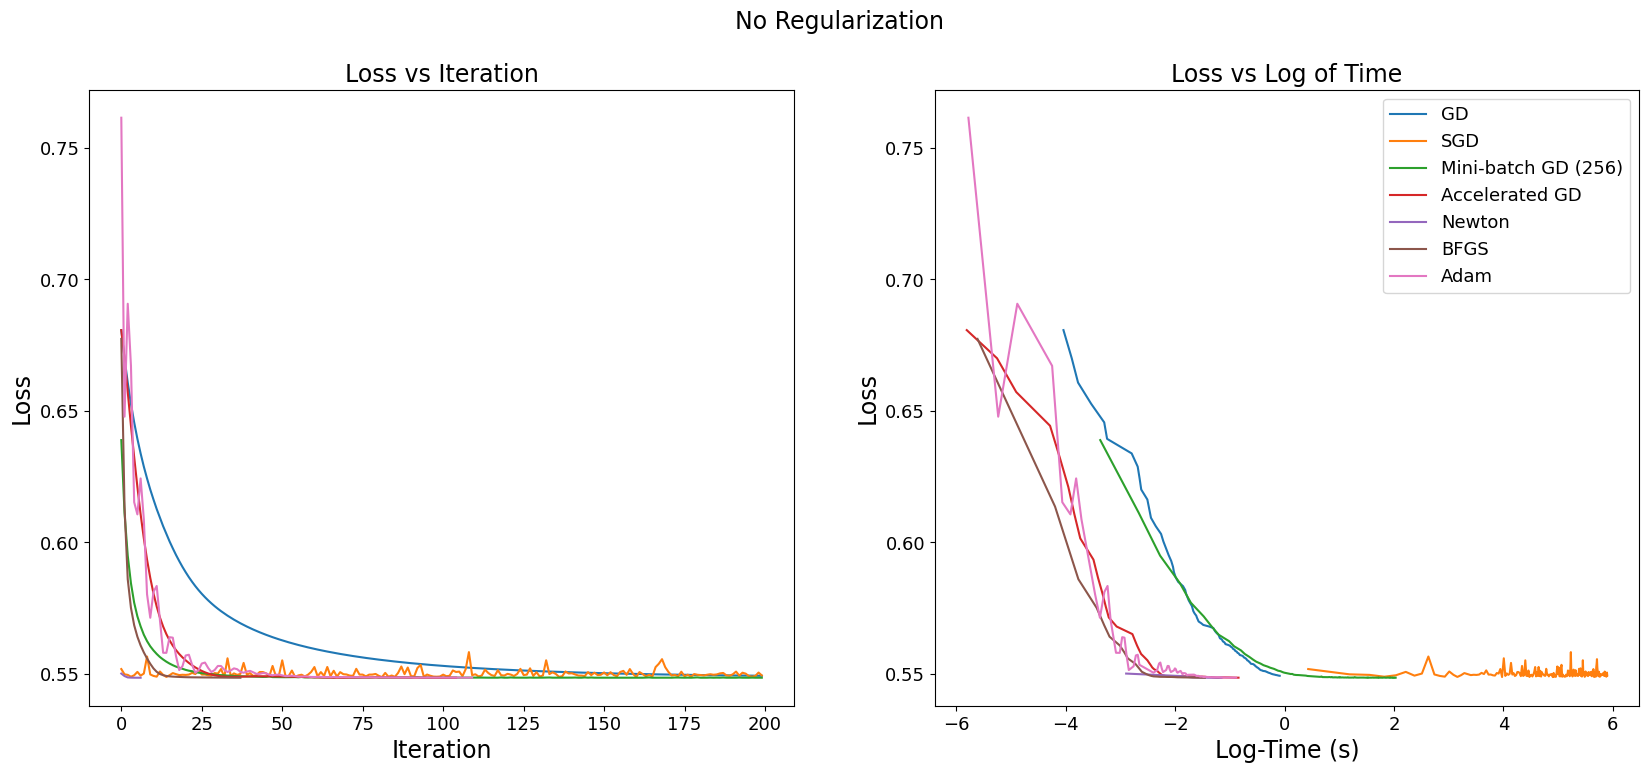

In [6]:
import matplotlib.pyplot as plt

# Plot loss for each learning rate with two subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Title for the subplots
fig.suptitle("No Regularization", fontsize=fontsize)

# Plot loss vs iteration
axs[0].set_title("Loss vs Iteration", fontsize=fontsize)
for logger in loggers:
    axs[0].plot(logger["loss"], label=logger["name"])

axs[0].set_xlabel("Iteration", fontsize=fontsize)
axs[0].set_ylabel("Loss", fontsize=fontsize)
axs[0].tick_params(axis='x', labelsize=fontsize - offset)
axs[0].tick_params(axis='y', labelsize=fontsize - offset)
# axs[0].legend()

# Plot loss vs time
axs[1].set_title("Loss vs Log of Time", fontsize=fontsize)
for logger in loggers:
    axs[1].plot(np.log(logger["time"]), logger["loss"], label=logger["name"])

axs[1].set_xlabel("Log-Time (s)", fontsize=fontsize)
axs[1].set_ylabel("Loss", fontsize=fontsize)
axs[1].tick_params(axis='x', labelsize=fontsize - offset)
axs[1].tick_params(axis='y', labelsize=fontsize - offset)
axs[1].legend(fontsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/ours_loss_no_regularization.png"
plt.savefig(file_path, format='png')
plt.show()

# Vs Scikit-learn

# Compare loss

In [16]:
# Sklearn Model
from sklearn.linear_model import LogisticRegression
from base import LogisticRegressionBFGS

# Our Model
bfgs = LogisticRegressionBFGS(
    learning_rate=0.8,
    num_iterations=200,
    regularization="None",
    fit_intercept=True, 
    log=True,
)


max_iters = 200
loss_loggers = {}

# Fit our model
bfgs.fit(X, y)
loss_loggers["BFGS (Ours)"] = bfgs.history

# Fit Sklearn model
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def loss_function(theta, X, y):
    z = np.dot(X, theta)
    h = sigmoid(z)
    return -np.mean(y * np.log(h) + (1 - y) * np.log(1 - h))

scikit_loss = []
X_ = np.hstack((np.ones((X.shape[0], 1)), X))
for i in range(1, max_iters+1):
    model = LogisticRegression(
        max_iter=i,
        fit_intercept=True,
        penalty="none",
        tol=1e-3
    )
    model.fit(X, y.ravel())

    coef = model.coef_.reshape(-1, 1)
    intercept = model.intercept_

    theta = np.vstack((intercept, coef))
    loss = loss_function(theta, X_, y)
    scikit_loss.append(loss)

loss_loggers["Scikit-learn"] = scikit_loss

/home/quyanh/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(


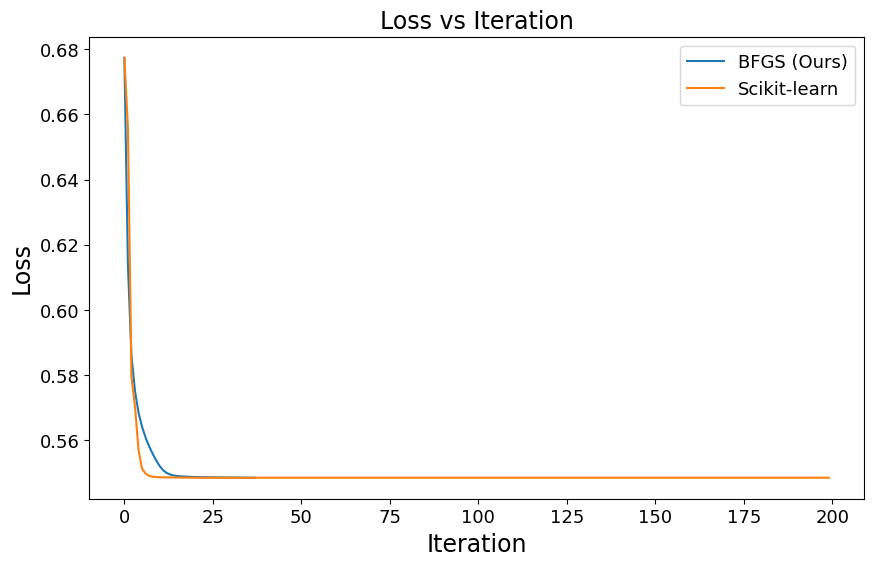

In [17]:
from matplotlib import pyplot as plt

# Plot loss 
plt.figure(figsize=(10, 6))
plt.title("Loss vs Iteration", fontsize=fontsize)
for name, loss in loss_loggers.items():
    plt.plot(loss, label=name)

plt.xlabel("Iteration", fontsize=fontsize)
plt.ylabel("Loss", fontsize=fontsize)
plt.tick_params(axis='x', labelsize=fontsize - offset)
plt.tick_params(axis='y', labelsize=fontsize - offset)
plt.legend(fontsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/compare_loss_no_regularization.png"
plt.savefig(file_path, format='png')

plt.show()

# Compare Time and Acc

In [22]:
from base import BaseLR
from time import time

# Romove log in class
class LogisticRegressionBFGS(BaseLR):
    def __init__(
        self,
        learning_rate=0.01,
        num_iterations=100,
        regularization="None",
        lambda_=1.0,
        fit_intercept=True,
        log=True,
        tol=1e-3
    ):
        super().__init__(learning_rate, num_iterations, regularization, lambda_, fit_intercept, log, tol)
        
    def fit(self, X, y):
        if self.fit_intercept:
            X = super()._BaseLR__add_intercept(X)
        
        self.theta = np.zeros((X.shape[1], 1))
        z = np.dot(X, self.theta)
        h = super()._BaseLR__sigmoid(z)
        gradient = self.gradient(h, y, X, self.theta)

        H = np.eye(X.shape[1])
        
        for _ in range(self.num_iterations):
            p = -H @ gradient
            s = self.learning_rate * p
            theta_new = self.theta + s
            
            z_new = np.dot(X, theta_new)
            h_new = super()._BaseLR__sigmoid(z_new)
            gradient_new = self.gradient(h_new, y, X, theta_new)
            
            delta_gradient = gradient_new - gradient
            
            r = 1/(delta_gradient.T@s)
            
            li = (np.eye(X.shape[1])-(r*((s@(delta_gradient.T)))))
            ri = (np.eye(X.shape[1])-(r*((delta_gradient@(s.T)))))
            
            H = li @ H @ ri + (r*((s@(s.T))))
            
            gradient = gradient_new
            self.theta = theta_new

            # Check to stop early
            if np.linalg.norm(gradient) < self.tol:
                break

In [25]:
# Our Model
bfgs = LogisticRegressionBFGS(
    learning_rate=0.8,
    num_iterations=200,
    regularization="None",
    fit_intercept=True, 
    log=True,
)

# Sklearn Model
from sklearn.linear_model import LogisticRegression

sklearn_lr = LogisticRegression(
    penalty=None,
    fit_intercept=True,
    max_iter=200,
    random_state=42,
    tol=1e-3
)

# Run 10 times to get a list of time
# After that plot boxplot
num_turns = 50

times = {
    "Ours": [],
    "Scikit-learn": []
}

for _ in range(num_turns):
    start = time()
    bfgs.fit(X, y)
    times["Ours"].append(time() - start)

    start = time()
    sklearn_lr.fit(X, y.ravel())
    times["Scikit-learn"].append(time() - start)


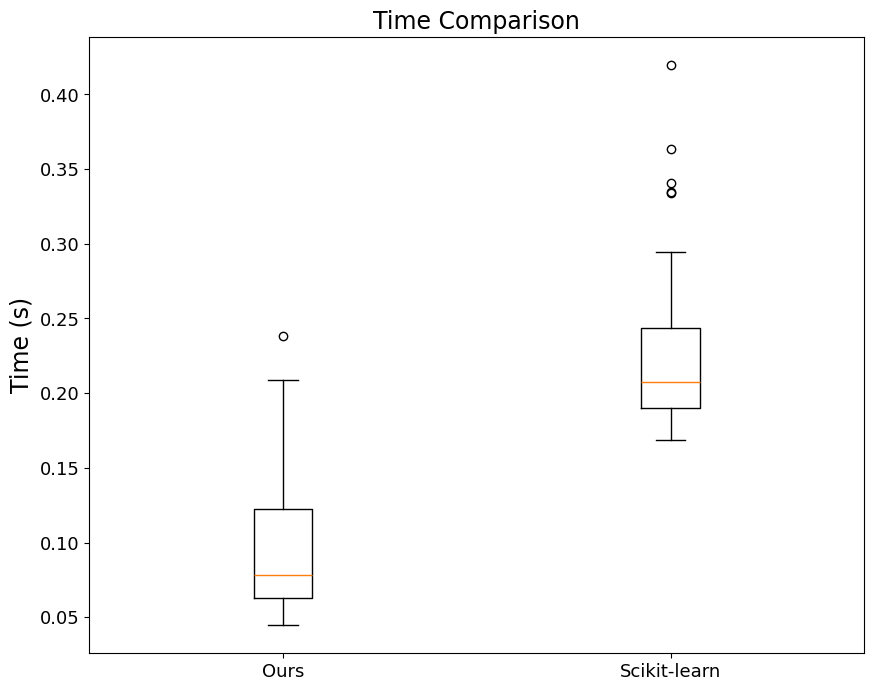

In [26]:
from matplotlib import pyplot as plt

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 8))

ax.boxplot(times.values())
ax.set_xticklabels(times.keys())
ax.set_title("Time Comparison", fontsize=fontsize)
ax.set_ylabel("Time (s)", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize - offset)
ax.tick_params(axis='y', labelsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/time_comparison.png"

plt.savefig(file_path, format='png')
plt.show()

In [11]:
# Run cross validation
from sklearn.model_selection import cross_val_score

# Our Model
bfgs = LogisticRegressionBFGS(
    learning_rate=0.4,
    num_iterations=200,
    regularization="None",
    fit_intercept=True, 
    log=True,
)

# Sklearn Model
from sklearn.linear_model import LogisticRegression

sklearn_lr = LogisticRegression(
    penalty='none',
    fit_intercept=True,
    max_iter=200,
    random_state=42,
    tol=1e-3
)

# Split data
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

num_turns = 50

scores = {
    "Ours": [],
    "Scikit-learn": []
}

for _ in range(num_turns):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    bfgs.fit(X_train, y_train)
    y_predict = bfgs.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    scores["Ours"].append(accuracy)

    sklearn_lr.fit(X_train, y_train)
    y_predict = sklearn_lr.predict(X_test)
    accuracy = accuracy_score(y_test, y_predict)
    scores["Scikit-learn"].append(accuracy)



/home/quyanh/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1182: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/home/quyanh/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = col

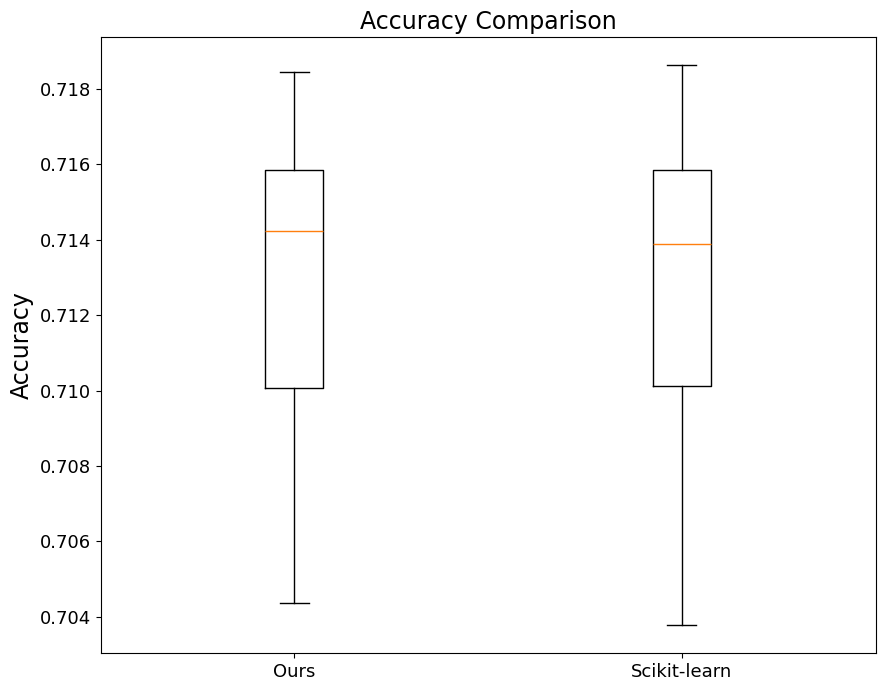

In [12]:
from matplotlib import pyplot as plt

# Plot boxplot
fig, ax = plt.subplots(figsize=(10, 8))

ax.boxplot(scores.values())
ax.set_xticklabels(scores.keys())
ax.set_title("Accuracy Comparison", fontsize=fontsize)
ax.set_ylabel("Accuracy", fontsize=fontsize)
ax.tick_params(axis='x', labelsize=fontsize - offset)
ax.tick_params(axis='y', labelsize=fontsize - offset)

# Save image
file_path = f"{folder_path}/accuracy_comparison.png"

plt.savefig(file_path, format='png')

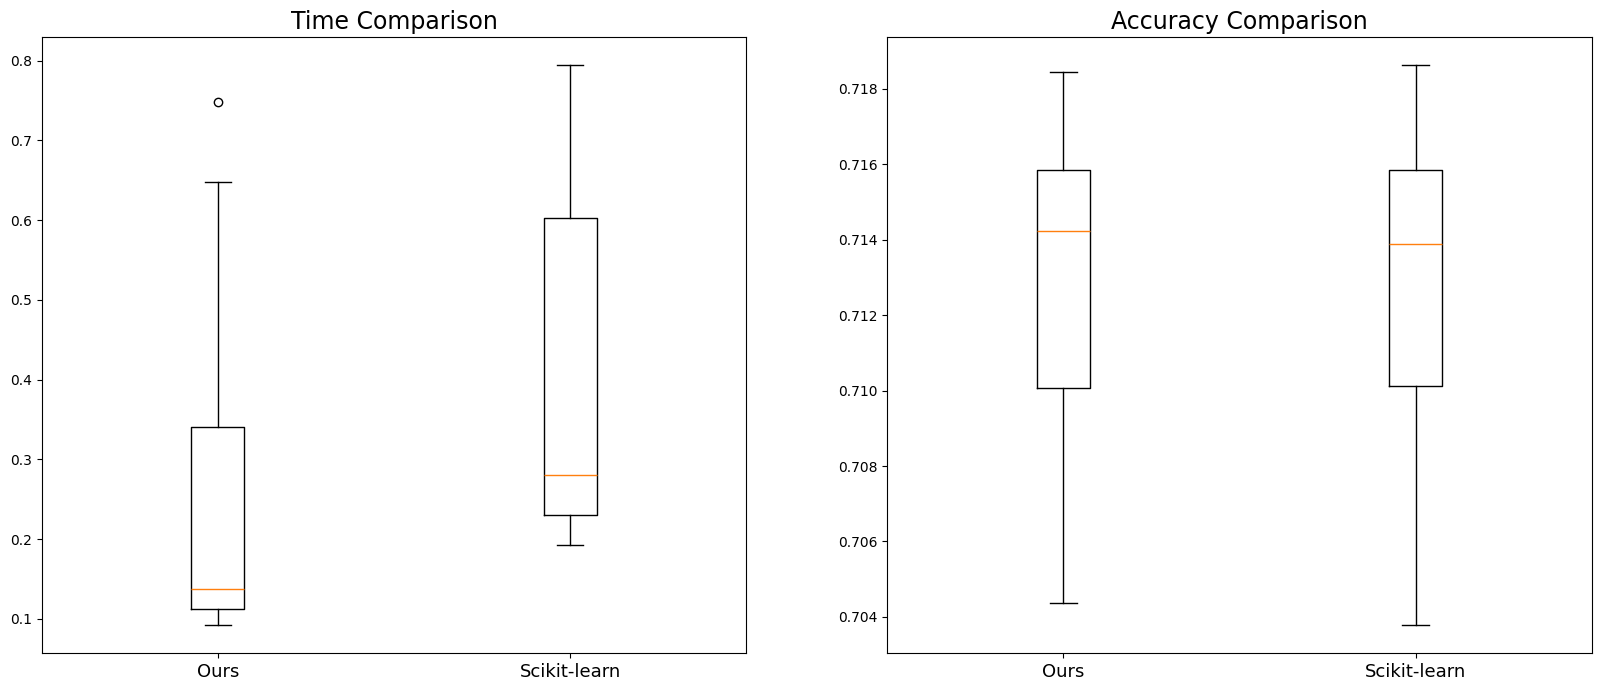

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Title for the subplots
# fig.suptitle("Comparision between Our Algorithm and Scikit-learn's Algorithm", fontsize=fontsize)

# Plot time
axs[0].boxplot(times.values())
axs[0].set_xticklabels(times.keys(), fontsize=fontsize - offset)
axs[0].set_title("Time Comparison", fontsize=fontsize)

# Plot accuracy
axs[1].boxplot(scores.values())
axs[1].set_xticklabels(scores.keys(), fontsize=fontsize - offset)
axs[1].set_title("Accuracy Comparison", fontsize=fontsize)

# Save image
file_path = f"{folder_path}/comparison.png"
plt.savefig(file_path, format='png')

plt.show()